In [43]:
#1
import pandas as pd
import numpy as np
import json

import psycopg2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import xgboost as xgb
from sklearn import metrics
from xgboost import plot_importance
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor   
import seaborn as sns
%matplotlib inline
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
plt.style.use('bmh')
from pandas import Series, DataFrame
from sklearn.model_selection import GridSearchCV


import math
import traceback
import sys
import re
import datetime
datetime.timedelta()

datetime.timedelta(0)

In [44]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10,duplicates='drop')
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True) 
    pd.set_option('display.max_columns', 9)
    #print(kstable)
     #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)


In [45]:
def adding_paid(data,paid):
    temp=pd.merge(data,paid,how='left',left_on='Loan_ID',right_on='loan_id')
    temp['paid_flag']=temp['paid_flag'].fillna(0)
    return temp

### Loading xgb Model

In [46]:
# load
file_name='KB_RR_xgb_v1.pkl'
xgb_model= pickle.load(open(file_name, "rb"))

## Aug_RR 

In [47]:
##Script-1 data
Aug22_ST1=pd.read_csv('data/input_data/processed_data/RR_Aug22_ST1.csv')
Aug22_ST1['month']=7
Aug22_ST1.shape

##concating the data
ST1=pd.concat([Aug22_ST1])

(43876, 10)

In [48]:
##Script-2 data
Aug22_ST2=pd.read_csv('data/input_data/processed_data/RR_Aug22_last3_calls_ST2.csv')
Aug22_ST2['month']=8
Aug22_ST2.shape

##concating the data
ST2=pd.concat([Aug22_ST2])

(43876, 175)

In [49]:
##Script-3 data
Aug22_ST3=pd.read_csv('data/input_data/processed_data/RR_Aug22_loan_ST3.csv')
Aug22_ST3['month']=8
Aug22_ST3.shape

Aug_paid=pd.read_excel('data/input_data/raw_data/aug22_paid_RR.xlsx')
Aug_paid['paid_flag']=1
Aug_paid=Aug_paid.rename(columns={'Loan No':'loan_id'})
Aug22_ST3=adding_paid(Aug22_ST3,Aug_paid[['loan_id','paid_flag']])

##concating the data
ST3=pd.concat([Aug22_ST3])

(43876, 11)

In [50]:
ST1.shape
ST2.shape
ST3.shape

(43876, 10)

(43876, 175)

(44104, 13)

In [51]:
## merging all ST1 & ST2 & ST3 data
ST3['Loan_ID']=ST3['Loan_ID'].astype(int).astype(str)
ST2['L3_Loan_ID']=ST2['L3_Loan_ID'].astype(int).astype(str)
ST1['Loan_ID']=ST1['Loan_ID'].astype(int).astype(str)

df_temp=pd.merge(ST3,ST2,how='left',left_on=['month','Loan_ID'],right_on=['month','L3_Loan_ID'])
df_temp.shape
df_final=pd.merge(df_temp,ST1,how='left',left_on=['month','Loan_ID'],right_on=['month','Loan_ID'])
df_final.shape

(44104, 187)

(44104, 195)

In [52]:
df=df_final.copy()

In [53]:
## Ratio between 0/1
for i in range(1,2,1):
    print("Month : ",i)
    df[df['month']==i].paid_flag.value_counts(normalize=True)*100

Month :  1


Series([], Name: paid_flag, dtype: float64)

In [54]:
## Selecting columns based on higher IV values:
sel_col=[
'month',
'Loan_ID',
'mean_call_duration',
'call_picked_%',
'call_response_%',
'L2_call_duration',
'L2_call_picked',
'L2_call_responsive',
'L2_Promiseto Pay',
'L2_RPC',
'L1_call_duration',
'L1_call_picked',
'L1_call_responsive',
'L1_Promiseto Pay',
'L1_RPC',
'Principle_due_%',
# 'Charges_due_%',
'Panelty_due_%',
'Principle_paid_%',
'paid_flag'    
]
df1=df[sel_col]

In [55]:
#downloading data for cross_check:
df1.to_csv('ITP_model_data.csv',index=False)

In [56]:
#dropping_columns
df1.drop(['call_picked_%'],axis=1,inplace=True)

In [57]:
df1=df1.fillna(0)
df1=round(df1,2)

In [58]:
df1.isnull().sum()

month                 0
Loan_ID               0
mean_call_duration    0
call_response_%       0
L2_call_duration      0
L2_call_picked        0
L2_call_responsive    0
L2_Promiseto Pay      0
L2_RPC                0
L1_call_duration      0
L1_call_picked        0
L1_call_responsive    0
L1_Promiseto Pay      0
L1_RPC                0
Principle_due_%       0
Panelty_due_%         0
Principle_paid_%      0
paid_flag             0
dtype: int64

In [59]:
OOT=df1.copy()

## Model Resutls

<Figure size 720x432 with 0 Axes>

Text(0, 0.5, 'TP rate')

Text(0.5, 0, 'FP rate')

Text(0.5, 1.0, 'ROC Curve')

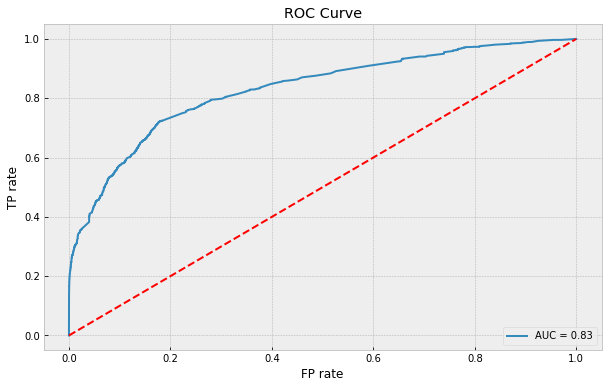

In [60]:
y_pred = xgb_model.predict_proba(OOT.drop(columns=['Loan_ID','month','paid_flag']))[:,1]
fp_r, tp_r, t = metrics.roc_curve(OOT['paid_flag'], y_pred)
#tp_r, fpr, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(10, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

In [61]:
t_opt=0.5
print("Threshold value is: %.2f" % t_opt)

Threshold value is: 0.50


In [62]:
y_pred = (xgb_model.predict_proba(OOT.drop(columns=['Loan_ID','month','paid_flag']))[:,1] >=t_opt).astype(bool)

In [63]:
## training data classification report
print(metrics.classification_report(OOT['paid_flag'], y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     42821
         1.0       0.97      0.03      0.05      1283

    accuracy                           0.97     44104
   macro avg       0.97      0.51      0.52     44104
weighted avg       0.97      0.97      0.96     44104



### conversion / precision / recall on top 1%, 5%, 10% and 30% 

#### OOT

In [64]:
y_OOT_pred = (xgb_model.predict_proba(OOT.drop(columns=['Loan_ID','month','paid_flag']))[:,1])
OOT_pred_label = (xgb_model.predict_proba(OOT.drop(columns=['Loan_ID','month','paid_flag']))[:,1] >=t_opt).astype(int)
df_OOT=pd.DataFrame({'prob':y_OOT_pred,'pred_label':OOT_pred_label,'actual_label':OOT['paid_flag']})
df_OOT=df_OOT.sort_values('prob',ascending=False).reset_index()

total_1=sum(df_OOT['actual_label'])

print("Results on top 1% data : ")
df_temp=df_OOT[:math.ceil(len(df_OOT)/100*1)]
total_sub_1=sum(df_OOT['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ", sum(df_temp['actual_label'])/sum(df_OOT['actual_label'])*100 , "\n")

print("Results on top 5% data : ")
df_temp=df_OOT[:math.ceil(len(df_OOT)/100*5)]
total_sub_1=sum(df_OOT['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ", sum(df_temp['actual_label'])/sum(df_OOT['actual_label'])*100, "\n")

print("Results on top 10% data : ")
df_temp=df_OOT[:math.ceil(len(df_OOT)/100*10)]
total_sub_1=sum(df_OOT['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ",sum(df_temp['actual_label'])/sum(df_OOT['actual_label'])*100, "\n")

print("Results on top 30% data : ")
df_temp=df_OOT[:math.ceil(len(df_OOT)/100*30)]
total_sub_1=sum(df_OOT['actual_label'])
print("precision : ",sum(df_temp['actual_label'])/len(df_temp)*100)
print("recall : ", sum(df_temp['actual_label'])/sum(df_OOT['actual_label'])*100, "\n")



Results on top 1% data : 
precision :  66.9683257918552
recall :  23.07092751363991 

Results on top 5% data : 
precision :  22.756119673617405
recall :  39.12704598597038 

Results on top 10% data : 
precision :  15.756064384493312
recall :  54.16991426344505 

Results on top 30% data : 
precision :  7.716142684401452
recall :  79.57911145752144 



### Shap Explainbility

In [65]:
import shap

In [66]:
explainer = shap.TreeExplainer(xgb_model)

In [67]:
shap_values = explainer.shap_values(OOT.drop(['Loan_ID','month','paid_flag'],axis=1))

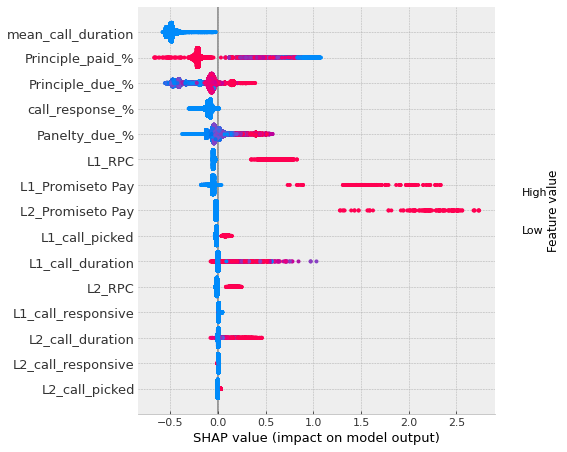

In [68]:
shap.summary_plot(shap_OOTues, OOT.drop(['Loan_ID','month','paid_flag'],axis=1), max_display=15)

#### End of Code <-----